# Setup Environment (for Windows with Conda)

## GPU Cuda Native Windows

In [44]:
# conda create -n audio_class python=3.10
# conda activate audio_class
# conda install -c conda-forge cudatoolkit=11.2 cudnn=8.1.0

## Install Libraries using Pip

In [ ]:
# Latest version of tensorflow that supports CUDA 11.2 in native Windows
%pip install "tensorflow<2.11"
%pip install "tensorflow-io==0.27.0"
%pip install numpy
%pip install matplotlib
%pip install seaborn
%pip install scikit-learn
%pip install pandas

In [46]:
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_io as tfio
import pandas as pd
import random
from IPython import display

## Making sure Tensorflow use GPU

In [47]:
print(tf.config.list_physical_devices('GPU')) # Use GPU, otherwise use CPU

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Set the Seed Value for Experiment Reproducibility.

In [48]:
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Dataset

## Install Dataset

In [49]:
DATA_PATH = './data/mini_speech_commands/'
data_dir = pathlib.Path(DATA_PATH)
if not data_dir.exists(): # Download data if not found
    print('Data directory not found, installing data...')
    tf.keras.utils.get_file(
        origin='http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip',
        extract=True,
        cache_dir='.',
        cache_subdir='data' 
    )

print('Completed')

Completed


In [50]:
label_names = np.array(tf.io.gfile.listdir(DATA_PATH))
label_names = label_names[(label_names != 'README.md') & (label_names != '.DS_Store')]
print('Label Names:', label_names) # List of labels

Label Names: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


## Data Loading Function

In [51]:
# Load the audio files, squeze the audio channels, and resample to 16kHz
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels) 
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Resample to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

## Store Data Splitting Info

In [52]:
# Initialize lists to store data
label_name_list = []
label_list = []
path_list = []

# Iterate over the data
for label in label_names:
    wav_dir = data_dir.joinpath(label)
    wav_paths = wav_dir.glob('*.wav')  # Get all wav files in the directory
    for wav_path in wav_paths:
        label_name_list.append(label)
        label_list.append(np.where(label_names == label)[0].item())
        path_list.append(str(wav_path))  # Convert path to string

# Create a DataFrame
df = pd.DataFrame({
    'Path': path_list,
    'Label Name': label_name_list,
    'Label': label_list
})

# Write the DataFrame to a CSV file
with open('path.csv', 'wb') as f:
    df.to_csv(f, index=False)

## Data Splitting with Stratified

In [53]:
from sklearn.model_selection import train_test_split

# Load the data from the CSV file
df = pd.read_csv('path.csv')

# Split the data into training and temp sets
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=SEED, stratify=df['Label'])

# Split the temp data into test and validation sets
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=SEED, stratify=temp_df['Label'])

# Create tensorflow dataset from the dataframes
all_data_ds = tf.data.Dataset.from_tensor_slices((df['Path'], df['Label']))
train_ds = tf.data.Dataset.from_tensor_slices((train_df['Path'], train_df['Label']))
val_ds = tf.data.Dataset.from_tensor_slices((val_df['Path'], val_df['Label']))
test_ds = tf.data.Dataset.from_tensor_slices((test_df['Path'], test_df['Label']))

# Explanatory Data Analysis (EDA)

## Label Distribution in All Sets

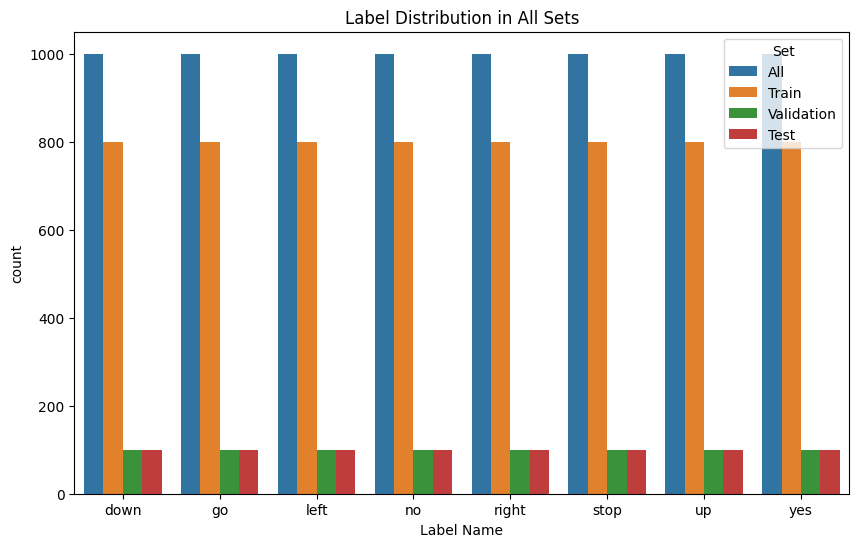

In [54]:
plot_all_df = df.copy()
plot_train_df = train_df.copy()
plot_val_df = val_df.copy()
plot_test_df = test_df.copy()

# Add a 'Set' column to each DataFrame
plot_all_df['Set'] = 'All'
plot_train_df['Set'] = 'Train'
plot_val_df['Set'] = 'Validation'
plot_test_df['Set'] = 'Test'

# Concatenate the DataFrames
plot_all_df = pd.concat([plot_all_df, plot_train_df, plot_val_df, plot_test_df])

# Create a count plot with different colors for each set
plt.figure(figsize=(10, 6))
sns.countplot(x='Label Name', hue='Set', data=plot_all_df)
plt.title('Label Distribution in All Sets')
plt.show()

## Label Statistics

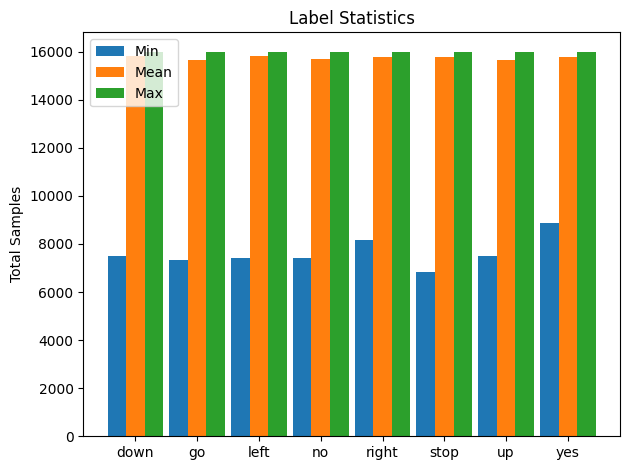

In [55]:
all_data_ds_loaded = all_data_ds.map(lambda path, label: (load_wav_16k_mono(path), label))
lengths = {} 
for tensor_wave, label in all_data_ds_loaded:
    if label_names[label] not in lengths:
        lengths[label_names[label]] = []
    lengths[label_names[label]].append(len(tensor_wave))

stats = {}
for key, value in lengths.items():
    stats[key] = [tf.math.reduce_min(value), tf.math.reduce_mean(value), tf.math.reduce_max(value)]

labels_plot = list(stats.keys())
min_values = [value[0] for value in stats.values()]
mean_values = [value[1] for value in stats.values()]
max_values = [value[2] for value in stats.values()]

x = np.arange(len(labels_plot))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, min_values, width, label='Min')
rects2 = ax.bar(x, mean_values, width, label='Mean')
rects3 = ax.bar(x + width, max_values, width, label='Max')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Total Samples')
ax.set_title('Label Statistics')
ax.set_xticks(x)
ax.set_xticklabels(labels_plot)
ax.legend()

fig.tight_layout()

plt.show()

# Preprocessing

## Load and Preprocess The Dataset

In [56]:
DESIRED_SAMPLE_RATE = 16000 # 16kHz

def preprocess(file_path, label): 
    # Load the audio file
    wav = load_wav_16k_mono(file_path)

    # Take the first 16000 samples for the audio file
    wav = wav[:DESIRED_SAMPLE_RATE]

    # Padding the audio file to have the same size
    zero_padding = tf.zeros([DESIRED_SAMPLE_RATE] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav], 0)

    # Set the shape of the audio file
    wav.set_shape([DESIRED_SAMPLE_RATE])
    return wav, label

In [57]:
# Apply the preprocessing function to the datasets
train_ds = train_ds.map(preprocess)
val_ds = val_ds.map(preprocess)
test_ds = test_ds.map(preprocess)

## Set Batch Size

In [58]:
BATCH_SIZE = 64

train_ds = train_ds.batch(BATCH_SIZE)
val_ds = val_ds.batch(BATCH_SIZE)
test_ds = test_ds.batch(BATCH_SIZE)

## Dataset Shape and Spec

In [59]:
for ex_audio, ex_label in train_ds.take(1):
    print(f'Audio Shape: {ex_audio.shape}; Label Shape: {ex_label.shape}')

print(f'Element Spec: {train_ds.element_spec}')


Audio Shape: (64, 16000); Label Shape: (64,)
Element Spec: (TensorSpec(shape=(None, 16000), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))


## Waveforms Visualization

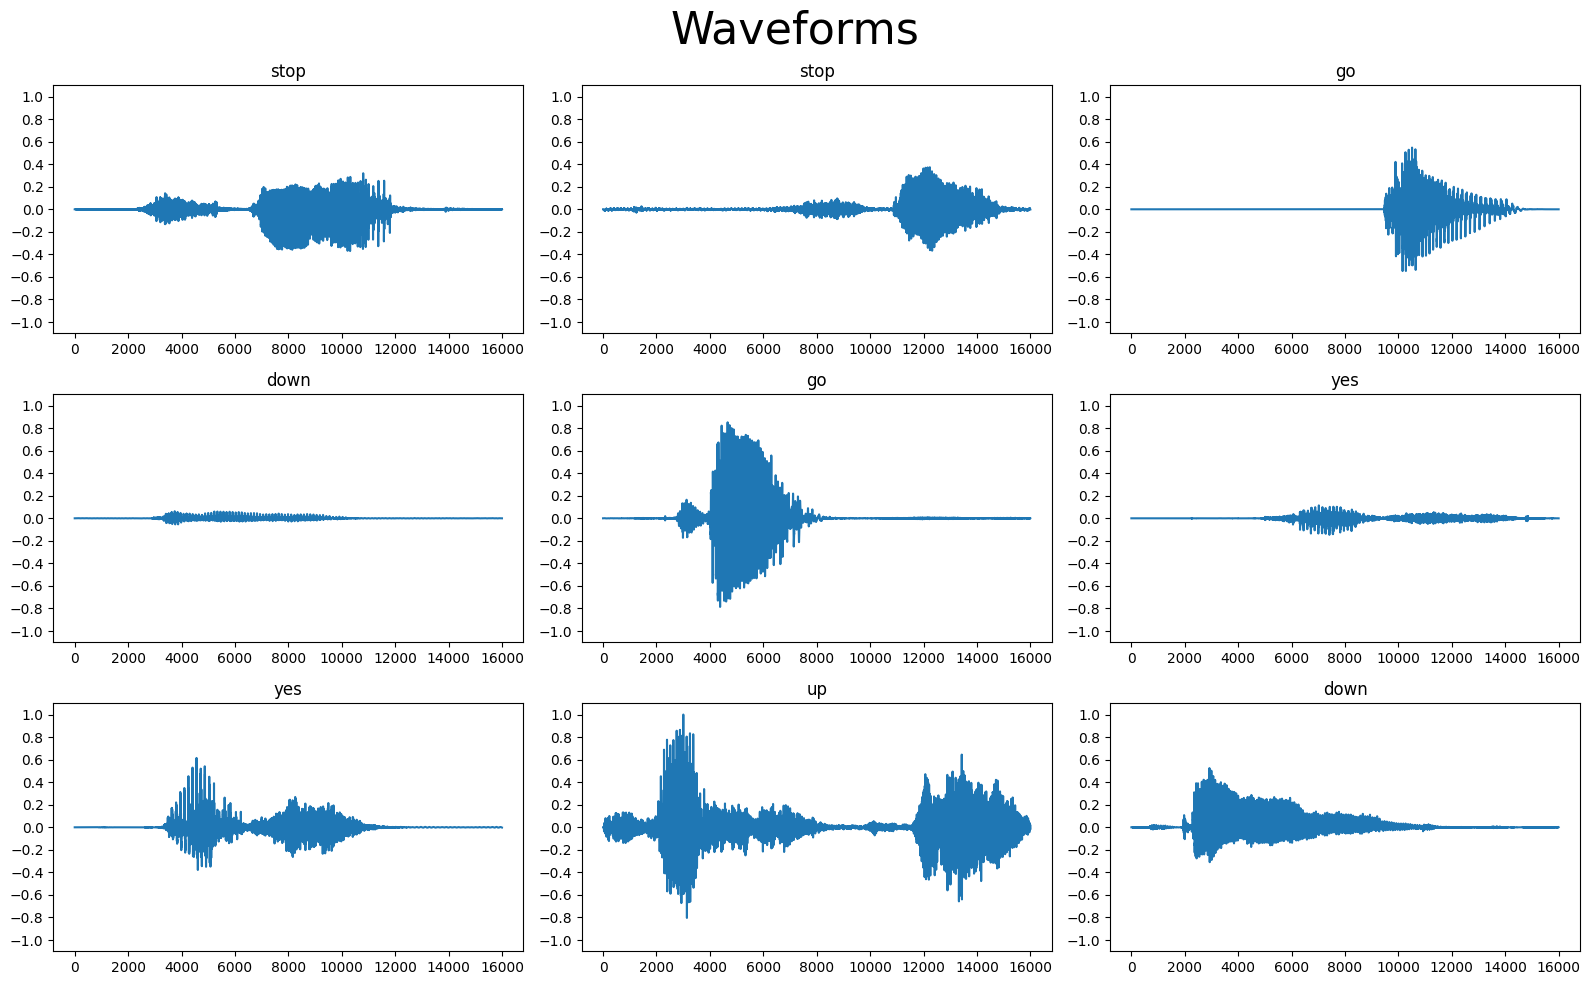

In [60]:
rows = 3
cols = 3
n = rows*cols

fig, axes = plt.subplots(rows, cols, figsize=(16,10))
for i in range(n):
    if i>= n:
        break

    r = i // cols
    c = i % cols

    ax = axes[r][c]
    ax.plot(ex_audio[i].numpy())
    ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
    ax.set_title(label_names[ex_label[i]])
    ax.set_ylim([-1.1, 1.1])

fig.suptitle('Waveforms', size=32)
fig.tight_layout()
plt.show()

## Convert Waveforms to Spectrograms

In [61]:
def get_spectrogram(waveform):
    # Convert the waveform to a spectrogram via a STFT.
    spectrogram = tf.signal.stft(
        waveform, 
        frame_length=400, # 25 ms
        frame_step=160 # 10 ms
    )

    # Obtain the magnitude of the STFT.
    spectrogram = tf.abs(spectrogram)

    # Add a channels dimension, so that the spectrogram can be used
    # as image-like input data with convolution layers (which expect
    # shape (batch_size, height, width, channels).
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram

def make_spec_ds(ds):

    # Apply the get_spectrogram function to the datasets.
    return ds.map(
        map_func = lambda audio, label: (get_spectrogram(audio), label),
        num_parallel_calls = tf.data.AUTOTUNE
    )

# Apply using map function
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

## Spectrogram Shape and Example

In [62]:
for i in range(3):
  label = label_names[ex_label[i]]
  waveform = ex_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=DESIRED_SAMPLE_RATE))

Label: stop
Waveform shape: (16000,)
Spectrogram shape: (98, 257, 1)
Audio playback


Label: stop
Waveform shape: (16000,)
Spectrogram shape: (98, 257, 1)
Audio playback


Label: go
Waveform shape: (16000,)
Spectrogram shape: (98, 257, 1)
Audio playback


In [63]:
for ex_sc, ex_sc_label in train_spectrogram_ds.take(1):
    print(f'Spectrogram Shape: {ex_sc.shape}; Label Shape: {ex_sc_label.shape}')

print(f'Element Spec: {train_spectrogram_ds.element_spec}')

Spectrogram Shape: (64, 98, 257, 1); Label Shape: (64,)
Element Spec: (TensorSpec(shape=(None, 98, 257, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))


## Spectrograms Visualization

In [64]:
def plot_spec(spectrogram, ax):
    if len(spectrogram.shape) > 2:
        assert len(spectrogram.shape) == 3
        spectrogram = np.squeeze(spectrogram, axis=-1)

    # Convert the frequencies to log scale and transpose, so that the time is represented on the x-axis (columns). Add an epsilon to avoid taking a log of zero.
    log_spec = np.log(spectrogram.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)

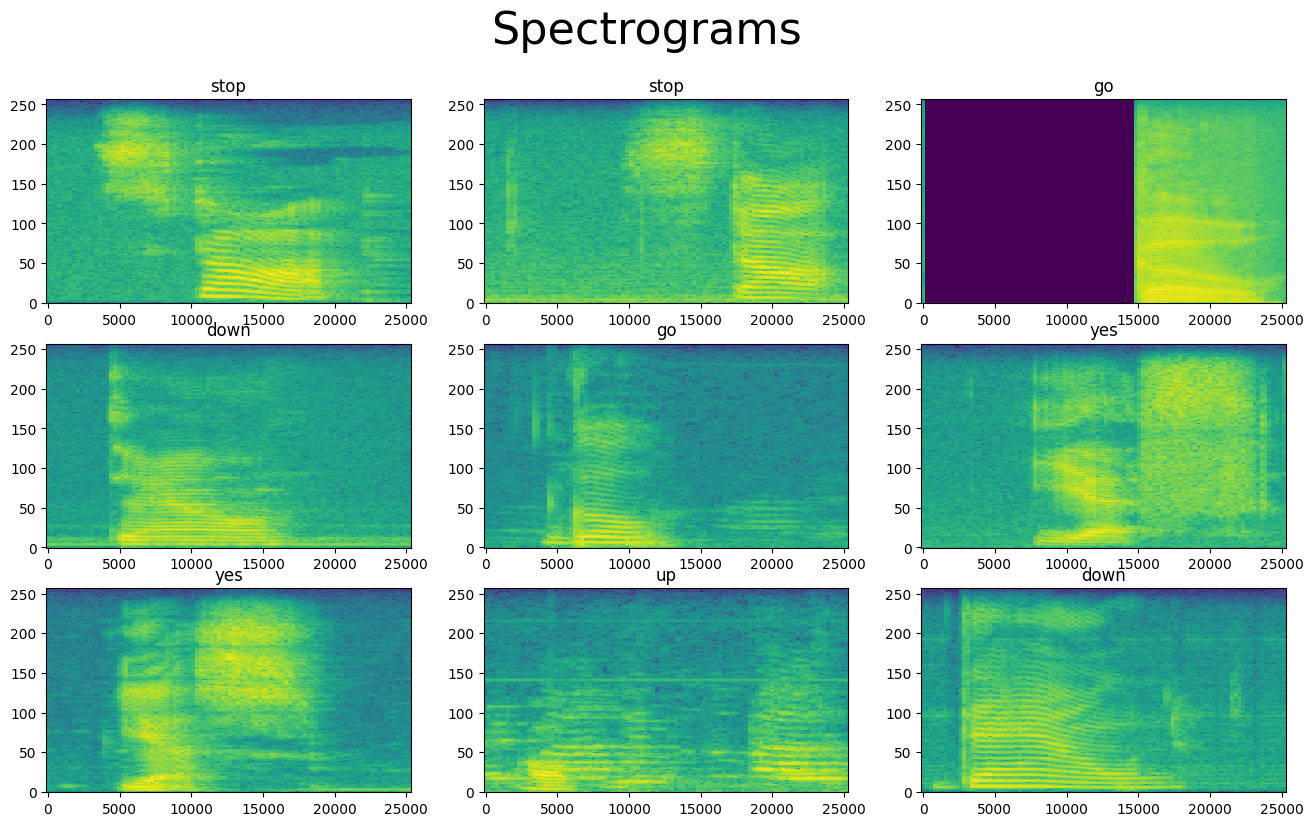

In [65]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // rows
    c = i % rows
    ax = axes[r][c]
    plot_spec(ex_sc[i].numpy(), ax)
    ax.set_title(label_names[ex_sc_label[i].numpy()])

fig.suptitle('Spectrograms', size=32)
plt.show()

## Comparison Visualization

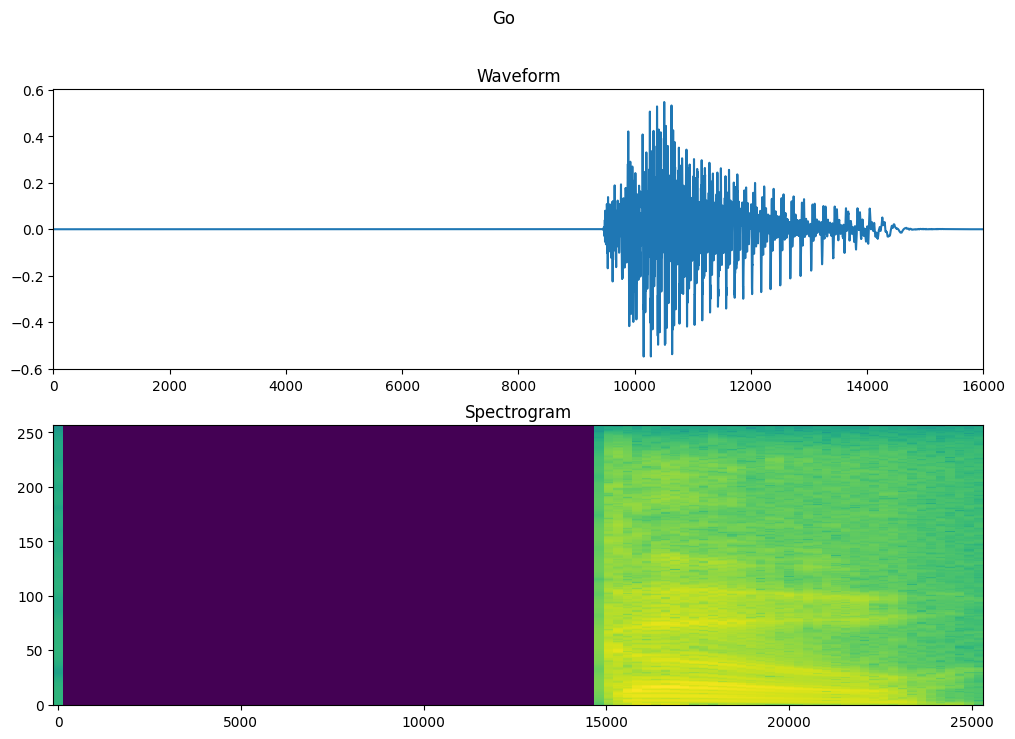

In [66]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spec(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

## Add Cache and Prefetch Operations to Reduce Read Latency While Training the Model

In [67]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(1000, seed=SEED).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

# Modelling

## Input Shape

In [68]:
input_shape = ex_sc.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

Input shape: (98, 257, 1)


In [69]:
from keras import models, layers
from keras import regularizers

L2_FACTOR = 0.001

## CNN

In [70]:
# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer_cnn = layers.Normalization()

# Fit the state of the layer to the spectrograms with `Normalization.adapt`.
norm_layer_cnn.adapt(train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model_cnn = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(64, 64),
    # Normalize.
    norm_layer_cnn,
    layers.Conv2D(64, 3, activation='relu'),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    # Flatten the feature maps to feed into the dense layer.
    layers.Flatten(),
    # Dense layer with L2 regularization.
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(L2_FACTOR)),
    layers.Dropout(0.5),
    layers.Dense(num_labels)
])

model_cnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_2 (Resizing)       (None, 64, 64, 1)         0         
                                                                 
 normalization_2 (Normalizat  (None, 64, 64, 1)        3         
 ion)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 62, 62, 64)        640       
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 128)      0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 30, 30, 128)      

## CNN-LSTM

In [71]:
# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer_cnnlstm = layers.Normalization()

# Fit the state of the layer to the spectrograms with `Normalization.adapt`.
norm_layer_cnnlstm.adapt(train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model_cnnlstm = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(64, 64),
    # Normalize.
    norm_layer_cnnlstm,
    layers.Conv2D(64, 3, activation='relu'),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    # Swap the spatial dimensions.
    layers.Permute((2, 1, 3)), # So the width is the time dimension
    # Apply LSTM across the spatial dimensions
    layers.TimeDistributed(layers.LSTM(128)),
    # Flatten the feature maps to feed into the dense layer.
    layers.Flatten(),
    # Dense layer with L2 regularization.
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(L2_FACTOR)),
    layers.Dropout(0.5),
    layers.Dense(num_labels)
])

model_cnnlstm.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_3 (Resizing)       (None, 64, 64, 1)         0         
                                                                 
 normalization_3 (Normalizat  (None, 64, 64, 1)        3         
 ion)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 62, 62, 64)        640       
                                                                 
 conv2d_7 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 30, 30, 128)      0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 30, 30, 128)      

## Compile

In [72]:
METRICS = [
    'accuracy'
]

In [73]:
model_cnn.compile(
    optimizer=tf.keras.optimizers.Adam(), 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    metrics=METRICS
)

model_cnnlstm.compile(
    optimizer=tf.keras.optimizers.Adam(), 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    metrics=METRICS
)

## Training

In [74]:
EPOCHS = 100
PATIENCE = 5

In [75]:
history_cnn = model_cnn.fit(
    train_spectrogram_ds, 
    validation_data=val_spectrogram_ds, 
    epochs=EPOCHS, 
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=PATIENCE)
)

Epoch 1/100
100/100 [==============================] - 3s 30ms/step - loss: 1.9340 - accuracy: 0.3798 - val_loss: 1.4032 - val_accuracy: 0.6375
Epoch 2/100
100/100 [==============================] - 2s 25ms/step - loss: 1.3045 - accuracy: 0.6477 - val_loss: 1.0677 - val_accuracy: 0.7412
Epoch 3/100
100/100 [==============================] - 2s 25ms/step - loss: 1.0927 - accuracy: 0.7430 - val_loss: 1.0854 - val_accuracy: 0.7825
Epoch 4/100
100/100 [==============================] - 2s 25ms/step - loss: 0.9922 - accuracy: 0.7900 - val_loss: 0.9651 - val_accuracy: 0.8225
Epoch 5/100
100/100 [==============================] - 2s 25ms/step - loss: 0.9189 - accuracy: 0.8173 - val_loss: 0.9360 - val_accuracy: 0.8313
Epoch 6/100
100/100 [==============================] - 2s 25ms/step - loss: 0.8494 - accuracy: 0.8480 - val_loss: 0.9014 - val_accuracy: 0.8450
Epoch 7/100
100/100 [==============================] - 2s 25ms/step - loss: 0.8235 - accuracy: 0.8556 - val_loss: 0.9154 - val_accuracy:

In [76]:
history_cnnlstm = model_cnnlstm.fit(
    train_spectrogram_ds, 
    validation_data=val_spectrogram_ds, 
    epochs=EPOCHS, 
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=PATIENCE)
)

Epoch 1/100
100/100 [==============================] - 5s 34ms/step - loss: 1.7234 - accuracy: 0.4022 - val_loss: 1.0891 - val_accuracy: 0.6400
Epoch 2/100
100/100 [==============================] - 3s 31ms/step - loss: 1.0223 - accuracy: 0.6686 - val_loss: 0.7513 - val_accuracy: 0.7825
Epoch 3/100
100/100 [==============================] - 3s 31ms/step - loss: 0.7473 - accuracy: 0.7791 - val_loss: 0.5835 - val_accuracy: 0.8375
Epoch 4/100
100/100 [==============================] - 3s 31ms/step - loss: 0.6288 - accuracy: 0.8209 - val_loss: 0.4870 - val_accuracy: 0.8775
Epoch 5/100
100/100 [==============================] - 3s 31ms/step - loss: 0.5310 - accuracy: 0.8581 - val_loss: 0.4459 - val_accuracy: 0.8963
Epoch 6/100
100/100 [==============================] - 3s 31ms/step - loss: 0.4811 - accuracy: 0.8775 - val_loss: 0.4033 - val_accuracy: 0.9062
Epoch 7/100
100/100 [==============================] - 3s 31ms/step - loss: 0.4314 - accuracy: 0.8911 - val_loss: 0.4166 - val_accuracy:

## Visualize the Loss and Performance

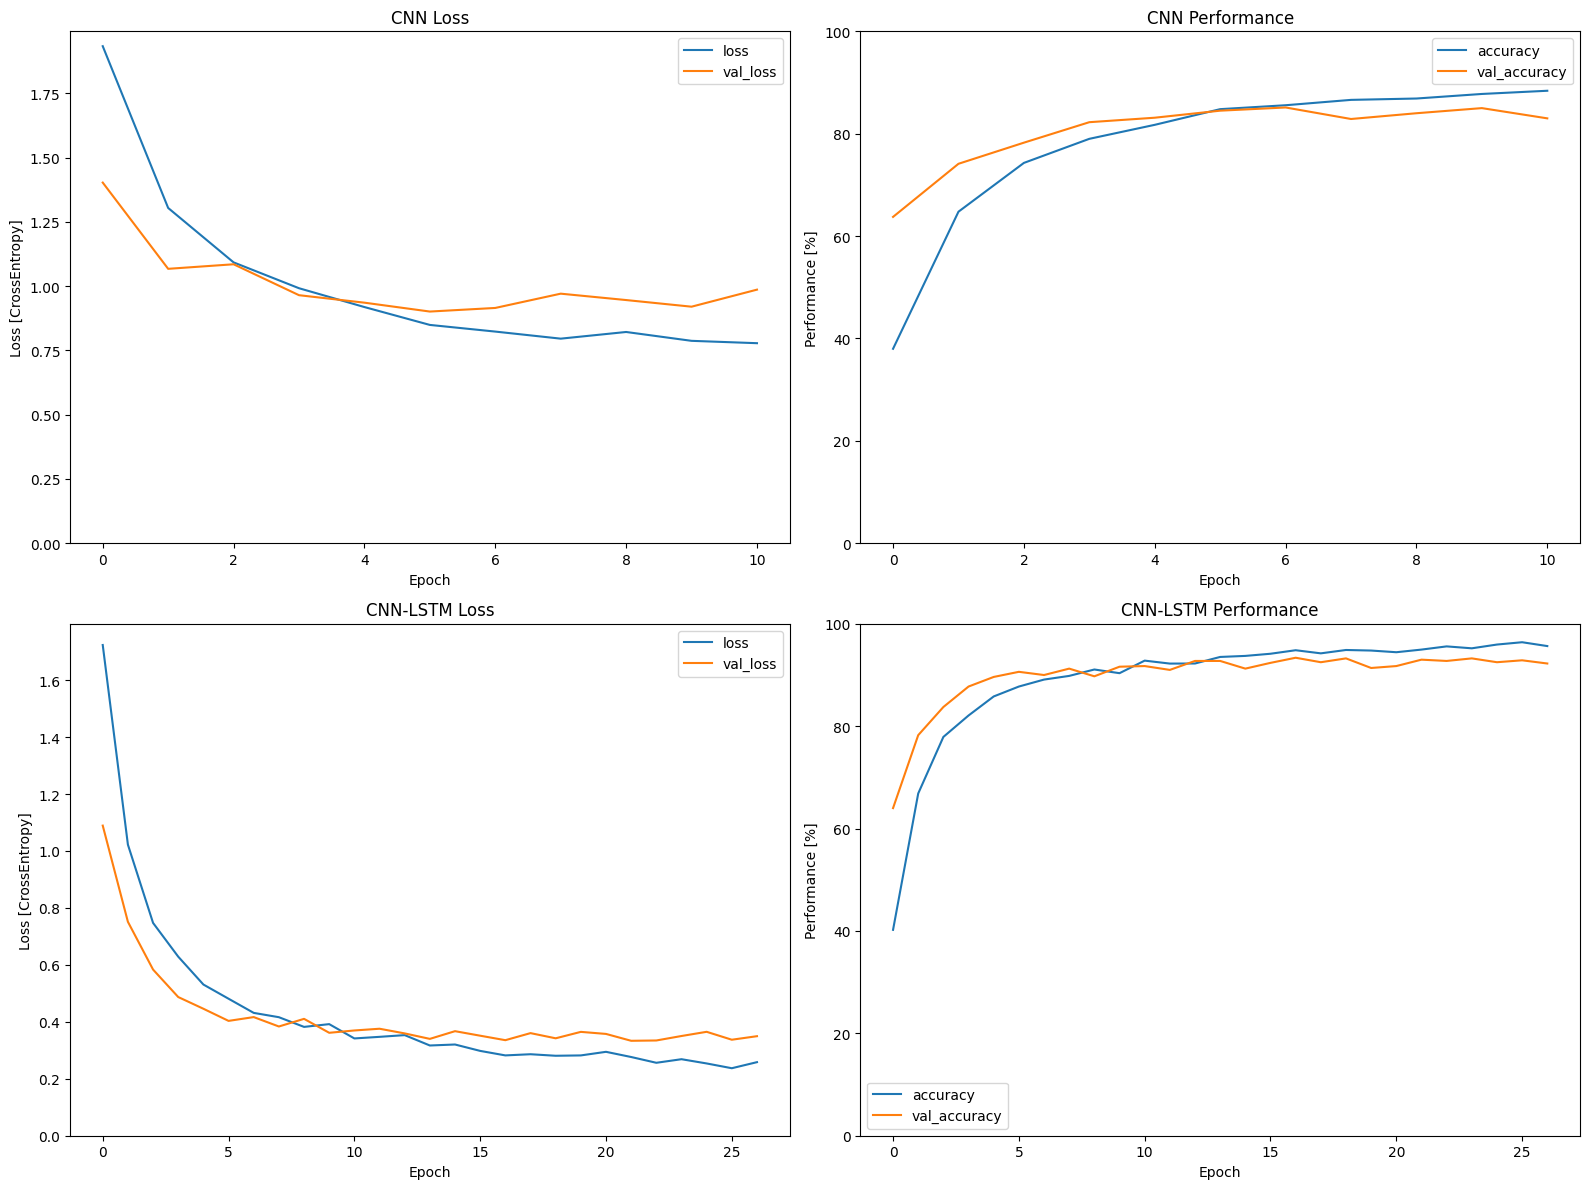

In [77]:
model_history = {
    'CNN': history_cnn,
    'CNN-LSTM': history_cnnlstm
}

fig, axes = plt.subplots(len(model_history), 2, figsize=(16, 6*len(model_history)))

for idx, (key, value) in enumerate(model_history.items()):

    metrics = value.history

    axes[idx, 0].plot(value.epoch, metrics['loss'], metrics['val_loss'])
    axes[idx, 0].legend(['loss', 'val_loss'])
    axes[idx, 0].set_ylim([0, max(axes[idx, 0].get_ylim())])
    axes[idx, 0].set_xlabel('Epoch')
    axes[idx, 0].set_ylabel('Loss [CrossEntropy]')
    axes[idx, 0].set_title(f'{key} Loss')

    axes[idx, 1].plot(
        value.epoch, 
        100*np.array(metrics['accuracy']), 
        100*np.array(metrics['val_accuracy'])
    )

    axes[idx, 1].legend(['accuracy', 'val_accuracy'])
    axes[idx, 1].set_ylim([0, 100])
    axes[idx, 1].set_xlabel('Epoch')
    axes[idx, 1].set_ylabel('Performance [%]')
    axes[idx, 1].set_title(f'{key} Performance')

plt.tight_layout()
plt.show()

## Save Model and History

In [78]:
model_cnn.save('./model/model_cnn.keras')
model_cnnlstm.save('./model/model_cnnlstm.keras')

history_cnn_df = pd.DataFrame(model_history['CNN'].history)
history_cnnlstm_df = pd.DataFrame(model_history['CNN-LSTM'].history)

if not pathlib.Path('./history').exists():
    pathlib.Path('./history').mkdir(parents=True, exist_ok=True)

with open('./history/history_cnn.csv', mode='wb') as f:
    history_cnn_df.to_csv(f, index=False)

with open('./history/history_cnnlstm.csv', mode='wb') as f:
    history_cnnlstm_df.to_csv(f, index=False)

# Evaluation

In [79]:
from sklearn.metrics import confusion_matrix, classification_report

## Load Model

In [80]:
model_cnn = tf.keras.models.load_model('./model/model_cnn.keras')
model_cnnlstm = tf.keras.models.load_model('./model/model_cnnlstm.keras')

## Predict The Test Set to Evaluate

In [81]:
# Get the true labels
y_true = tf.concat(list(test_spectrogram_ds.map(lambda spec, label: label)), axis=0)

In [82]:
model_cnn.evaluate(test_spectrogram_ds, return_dict=True)
y_pred_cnn = model_cnn.predict(test_spectrogram_ds)
y_pred_cnn = tf.argmax(y_pred_cnn, axis=1)

13/13 [==============================] - 0s 6ms/step


In [83]:
model_cnnlstm.evaluate(test_spectrogram_ds, return_dict=True)
y_pred_cnnlstm = model_cnnlstm.predict(test_spectrogram_ds)
y_pred_cnnlstm = tf.argmax(y_pred_cnnlstm, axis=1)

13/13 [==============================] - 0s 9ms/step


## Classification Report

In [84]:
print("Classification Report CNN")
print(classification_report(y_true, y_pred_cnn, target_names=label_names))
print("\nClassification Report CNN-LSTM")
print(classification_report(y_true, y_pred_cnnlstm, target_names=label_names))

Classification Report CNN
              precision    recall  f1-score   support

        down       0.75      0.87      0.81       100
          go       0.77      0.75      0.76       100
        left       0.95      0.83      0.89       100
          no       0.75      0.77      0.76       100
       right       0.98      0.90      0.94       100
        stop       0.87      0.83      0.85       100
          up       0.76      0.91      0.83       100
         yes       0.95      0.87      0.91       100

    accuracy                           0.84       800
   macro avg       0.85      0.84      0.84       800
weighted avg       0.85      0.84      0.84       800


Classification Report CNN-LSTM
              precision    recall  f1-score   support

        down       0.88      0.91      0.90       100
          go       0.81      0.82      0.82       100
        left       0.93      0.94      0.94       100
          no       0.85      0.89      0.87       100
       right       0

## Confusion Matrix

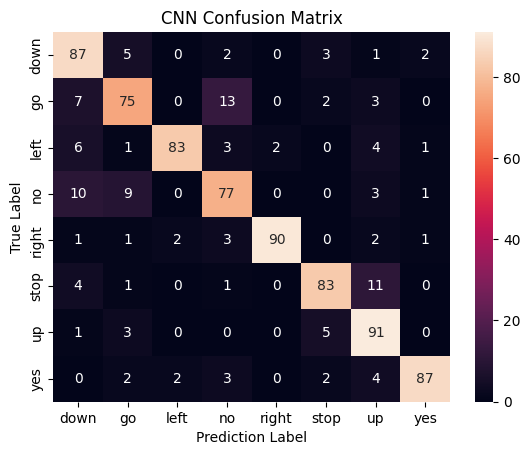

In [85]:
cm = confusion_matrix(y_true, y_pred_cnn)
sns.heatmap(cm, annot=True, xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Prediction Label')
plt.ylabel('True Label')
plt.title('CNN Confusion Matrix')
plt.show()

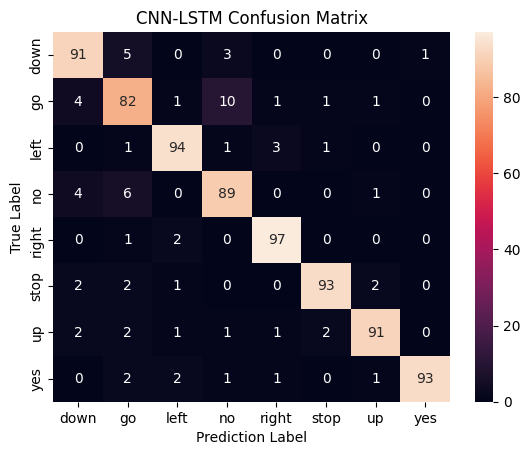

In [86]:
cm = confusion_matrix(y_true, y_pred_cnnlstm)
sns.heatmap(cm, annot=True, xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Prediction Label')
plt.ylabel('True Label')
plt.title('CNN-LSTM Confusion Matrix')
plt.show()